## X-ray Prediction


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

#Using this to check for deplicates in the dataset
import imagehash

#For image transfering 
import shutil

#To deal with the imballance problem
from imblearn.over_sampling import SMOTE

#Model
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

#For Augmenting
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#For the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

from collections import Counter

2024-04-26 23:01:37.911262: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 23:01:37.951345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 23:01:38.668470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Taking A look at the dataset

#### Checking for Duplicates Image

In [2]:
def duplicate_data_check(class_dir):
    total = 0
    image_hashes = {}
        
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpeg')]
        
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
            
        with Image.open(image_path) as img:
            img_hash = imagehash.average_hash(img)
            if img_hash in image_hashes:
                total += 1
            else:
                image_hashes[img_hash] = image_file


    print("There are " , total , "duplicates")

print("Training set Normal check ")
duplicate_data_check("./Original_Data/train/NORMAL")

print("\nTraining set Pneumonia check ")
duplicate_data_check("./Original_Data/train/PNEUMONIA")

print("\nTesting set Normal check ")
duplicate_data_check("./Original_Data/test/NORMAL")

print("\nTesting set Pneumonia  check ")
duplicate_data_check("./Original_Data/test/PNEUMONIA")

Training set Normal check 
There are  81 duplicates

Training set Pneumonia check 
There are  131 duplicates

Testing set Normal check 
There are  6 duplicates

Testing set Pneumonia  check 
There are  7 duplicates


### Editing the dataset

This will allow is to easilly deal with problems such, unballanced data and duplicates.

In [3]:
def move_images(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):

            source_path = os.path.join(source_dir, filename)
            destination_path = os.path.join(destination_dir, filename)
            
            shutil.copyfile(source_path, destination_path)
    
# Train Normal
move_images("./Original_Data/train/NORMAL", "./model_Data/NORMAL")
# Test Normal
move_images("./Original_Data/test/NORMAL", "./model_Data/NORMAL")
# Train Pneumonia
move_images("./Original_Data/train/PNEUMONIA", "./model_Data/PNEUMONIA")
# Test Pneumonia
move_images("./Original_Data/test/PNEUMONIA", "./model_Data/PNEUMONIA")


#### Removing the duplicates

To remove the duplicates we will just adjust the function above. Also, duplicated the data set so theres still a copy of the original.

In [4]:
def remove_duplicates(class_dir):
    removed_count = 0
    image_hashes = {}
    
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpeg')]
    
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        
        with Image.open(image_path) as img:
            img_hash = imagehash.average_hash(img)
            
            if img_hash in image_hashes:
                os.remove(image_path)
                removed_count += 1
            else:
                image_hashes[img_hash] = image_file
    
    print("Total duplicates removed:", removed_count)


print("Normal remove duplicates")
remove_duplicates("./model_Data/NORMAL")

print("\nPneumonia remove duplicates")
remove_duplicates("./model_Data/PNEUMONIA")



Normal remove duplicates
Total duplicates removed: 100

Pneumonia remove duplicates
Total duplicates removed: 162


### Getting the images and Labelling

In [5]:
def creating_dataframe(dataset_dir):
    data = {'image_path': [], 'label': []}

    normal_dir = os.path.join(dataset_dir, 'NORMAL')
    for filename in os.listdir(normal_dir):
        if filename.endswith('.jpeg'):
            
            image_path = os.path.join(normal_dir, filename)
            
            data['image_path'].append(image_path)
            data['label'].append(0)  

    pneumonia_dir = os.path.join(dataset_dir, 'PNEUMONIA')
    for filename in os.listdir(pneumonia_dir):
        if filename.endswith('.jpeg'):
            
            image_path = os.path.join(pneumonia_dir, filename)
            
            data['image_path'].append(image_path)
            data['label'].append(1) 

    df = pd.DataFrame(data)
    return df

df = creating_dataframe('./model_Data')

In [6]:
df.head()
df.tail()

,image_path,label
5589,./model_Data/PNEUMONIA/person328_bacteria_1515...,1
5590,./model_Data/PNEUMONIA/person534_bacteria_2253...,1
5591,./model_Data/PNEUMONIA/person955_bacteria_2880...,1
5592,./model_Data/PNEUMONIA/person1390_bacteria_353...,1
5593,./model_Data/PNEUMONIA/person101_bacteria_484....,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5594 entries, 0 to 5593
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5594 non-null   object
 1   label       5594 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.5+ KB


### Distrbution of the data for each label

In [8]:
label_counts = df['label'].value_counts()

count_label_N = label_counts.get(0, 0)

count_label_P = label_counts.get(1, 0)

print("Number of 'Normal' labels:", count_label_N)
print("Number of 'Pneumonia' labels:", count_label_P)


Number of 'Normal' labels: 1483
Number of 'Pneumonia' labels: 4111


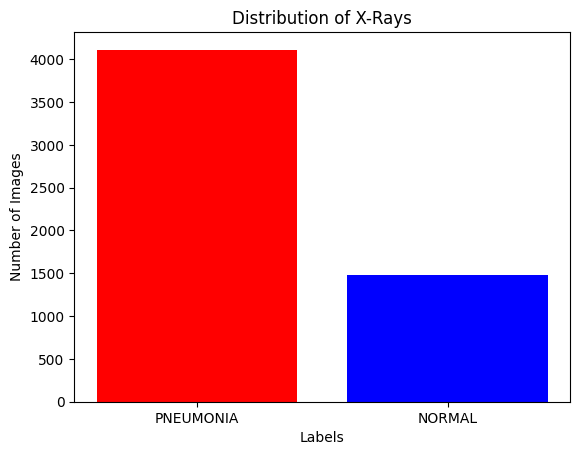

Pneumonia count 4111
Normal count 1483


In [9]:
labels = ['PNEUMONIA', 'NORMAL']
counts = [count_label_P, count_label_N]

plt.bar(labels, counts, color=['red', 'blue'])
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of X-Rays')
plt.show()

print("Pneumonia count" , count_label_P)
print("Normal count" ,count_label_N)

There is a huge imballance in the data set for Normal and Pneumonia x-ray results. With Pneumonia having a little over 4100 images and Normal only having around 1500. To deal with this imballance we will use SMOTE, which is synthetic minority over-sampling techniuque.

### Seperating Training and Testing Data

In [10]:
train_df, test_df = train_test_split(df, test_size=0.3)
train_df, val_df = train_test_split(train_df, test_size=0.3)

Number of 'Normal' labels: 725
Number of 'Pneumonia' labels: 2015


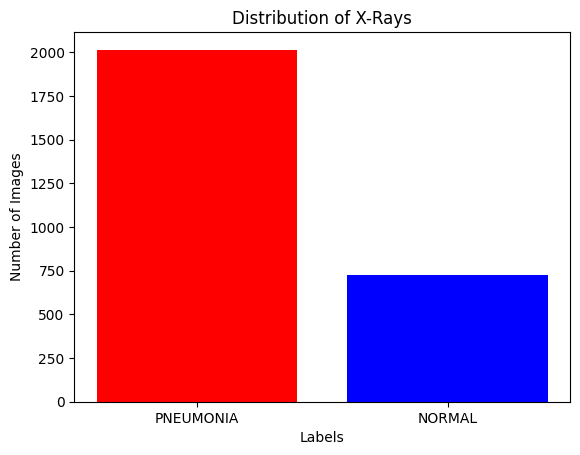

In [11]:
label_counts = train_df['label'].value_counts()

count_label_N = label_counts.get(0, 0)

count_label_P = label_counts.get(1, 0)

print("Number of 'Normal' labels:", count_label_N)
print("Number of 'Pneumonia' labels:", count_label_P)

labels = ['PNEUMONIA', 'NORMAL']
counts = [count_label_P, count_label_N]

plt.bar(labels, counts, color=['red', 'blue'])
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of X-Rays')
plt.show()

### Getting and processing images

In [12]:
def process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img 


X_paths = train_df['image_path'].values
y = train_df['label'].values

X = np.array([process_image(path) for path in X_paths] )

y = train_df['label'].values

### Adding more data using SMOTE

In [13]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)

print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)


Shape of X_resampled: (4030, 150528)
Shape of y_resampled: (4030,)


In [14]:
label_counts = Counter(y_resampled)

print("Number of Normal labels after oversampling:", label_counts[0])
print("Number of Pneumonia labels after oversampling:", label_counts[1])


Number of Normal labels after oversampling: 2015
Number of Pneumonia labels after oversampling: 2015


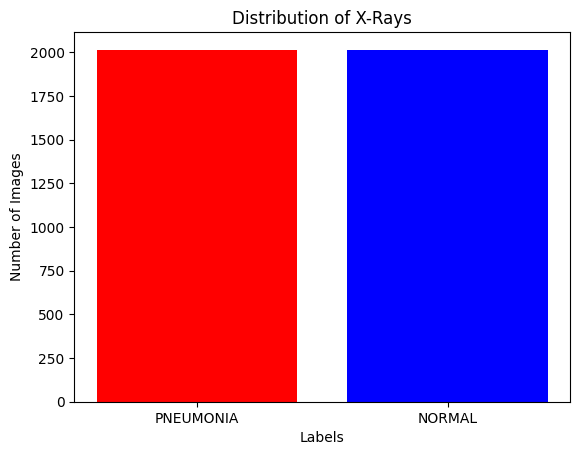

In [15]:
labels = ['PNEUMONIA', 'NORMAL']
counts = [label_counts[1], label_counts[0]]

plt.bar(labels, counts, color=['red', 'blue'])
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of X-Rays')
plt.show()

### Getting Validation Data

In [16]:
X_paths_val = val_df['image_path'].values
yval = val_df['label'].values
X_val = np.array([process_image(path) for path in X_paths_val] )

## Model

In [17]:
model = Sequential([
    Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()



/home/karam/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 64)   │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,262,657 (73.48 MB)

 Trainable params: 19,262,657 (73.48 MB)

 Non-trainable params: 0 (0.00 B)

### Data Augmentation

In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,      
    shear_range=0.1,        
    zoom_range=0.1,        
    horizontal_flip=True,   
)

num_samples, img_height, img_width, num_channels = X.shape

train_generator = datagen.flow(
    X_resampled.reshape(-1, img_height, img_width, num_channels),  
    y_resampled,  
    batch_size = 32
)

In [19]:
history = model.fit(
    train_generator,
    epochs=9,
    validation_data=(X_val, yval)
)

Epoch 1/9


/home/karam/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 50s 383ms/step - accuracy: 0.6392 - loss: 0.6286 - val_accuracy: 0.8689 - val_loss: 0.2933
Epoch 2/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 47s 365ms/step - accuracy: 0.8961 - loss: 0.2618 - val_accuracy: 0.9438 - val_loss: 0.1583
Epoch 3/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 50s 388ms/step - accuracy: 0.9142 - loss: 0.2323 - val_accuracy: 0.9362 - val_loss: 0.1708
Epoch 4/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 383ms/step - accuracy: 0.9183 - loss: 0.2181 - val_accuracy: 0.9311 - val_loss: 0.1705
Epoch 5/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9255 - loss: 0.2036 - val_accuracy: 0.9506 - val_loss: 0.1504
Epoch 6/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 47s 365ms/step - accuracy: 0.9330 - loss: 0.1905 - val_accuracy: 0.9132 - val_loss: 0.1980
Epoch 7/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 381ms/step - accuracy: 0.9337 - loss: 0.1804 - val_accuracy: 0.9506 - val_loss: 0.1503
Epoch 8/9
126/126 ━━━━━━━━━━━━━━━━━━━━ 50s 393ms/step - accuracy: 0.9334 - loss: 0.1824 - val_accura

In [20]:
X_paths_test = test_df['image_path'].values
ytest = test_df['label'].values
X_test = np.array([process_image(path) for path in X_paths_test] )


In [21]:
test_loss, test_accuracy = model.evaluate(X_test, ytest)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9286 - loss: 0.1704
Test Loss: 0.15938270092010498
Test Accuracy: 0.9374627470970154


### Accuracy Plot

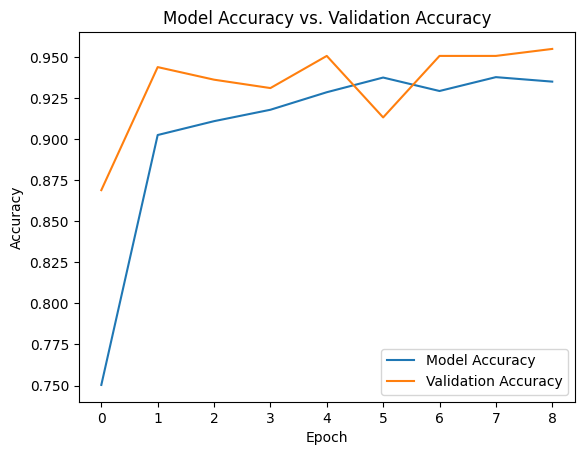

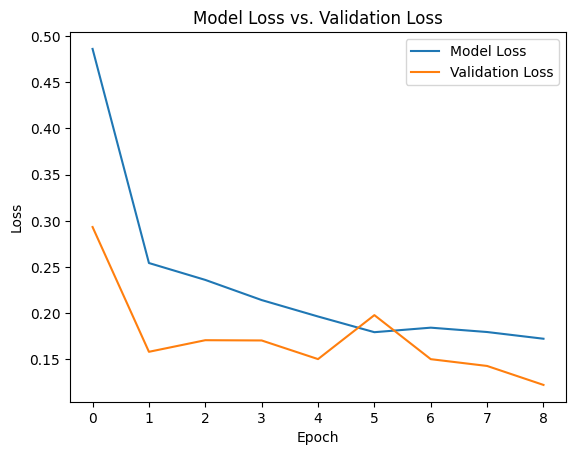

In [22]:
plt.plot(history.history['accuracy'], label='Model Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Model Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss vs. Validation Loss')
plt.legend()
plt.show()

### Testing Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


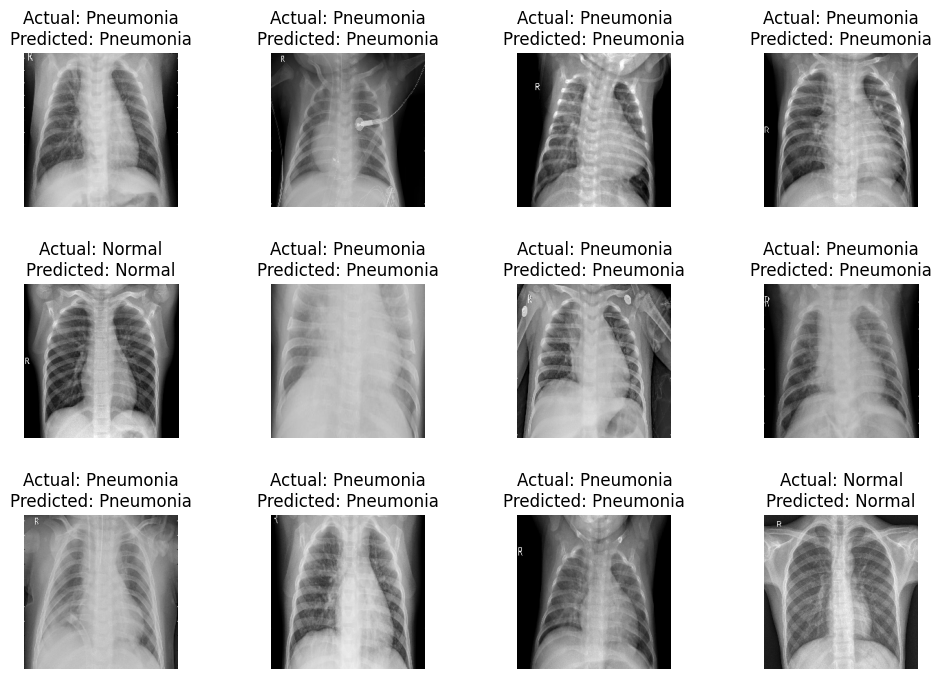

In [23]:
sampled_df = df.sample(n=12)

images = []
actual_labels = sampled_df['label'].tolist()

for img_path in sampled_df['image_path']:
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    images.append(img_array)

images = np.array(images) / 255.0 
predictions = model.predict(images)
predicted_labels = ['Pneumonia' if pred > 0.5 else 'Normal' for pred in predictions]

plt.figure(figsize=(12, 8))
for i in range(len(sampled_df)):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Actual: {'Normal' if actual_labels[i] == 0 else 'Pneumonia'}\nPredicted: {predicted_labels[i]}")
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


### Confusion Matrix

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step


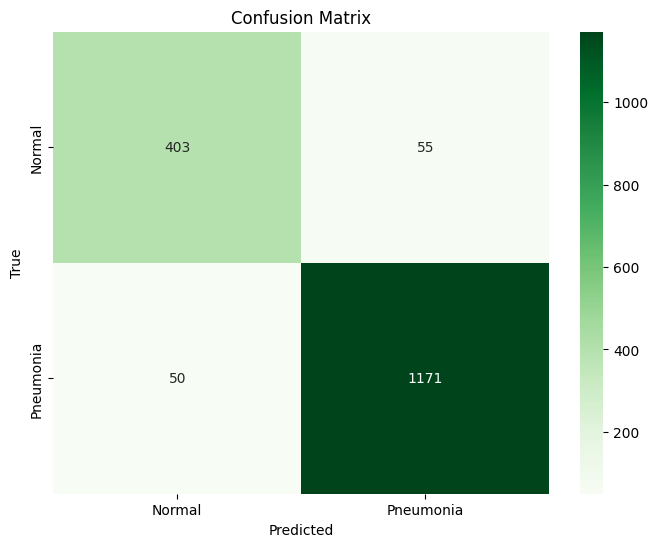

In [24]:
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

cm = confusion_matrix(ytest, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
